# ORB: An Efficient Alternative to SIFT or SURF

Rublee, Ethan; Rabaud, Vincent; Konolige, Kurt; Bradski, Gary (2011). "ORB: an efficient alternative to SIFT or SURF". *IEEE International Conference on Computer Vision (ICCV).*

# Agenda

1. Motivation (common CV applications and pipelines)
2. Why ORB?
3. Algorithm
4. Scalable matching

# Motivation

*All of this research is pre-AlexNet.*

Typical CV applications:
* Panorama stitching
* Object detection
* Augmented reality
* SLAM: Simultaneous Localisation and Mapping (***what we're interested in***)


Pipeline:
1. Identify features
2. Create descriptors
3. Match descriptors across images or a database of images

### About SLAM and Hermes (Project 1K)

Automate/speed-up warehouse floor mapping with "real-world" coordinates.

Localise pickers to this map in real-time.

![gif](https://thumbs.gfycat.com/AlarmingFamiliarAndalusianhorse-mobile.mp4)

*Stereo ORB-SLAM (ORB-SLAM2)*

<img src="feature_based_stereo_dense.png" width="60%">

3D reconstruction.

*Feature-based Visual Odometry Prior for Real-time Semi-dense Stereo SLAM*

# Why ORB?

Created by OpenCV contributors at Willow Garage as a fast, robust, and open-source alternative to SIFT.

1. ORB gives competitive or superior performance to SIFT, SURF for descriptor matching.
2. For large-scale image matching, ORB outperforms SIFT while being around two orders of magnitudes faster, enabling real-time, on-device computation.
3. ORB is open-sourced under BSD.

> An additional benefit of ORB is that it is free from the licensing restrictions of SIFT and SURF.

# Algorithm

1. Generate $M > N$ features using FAST.
2. Select top $N$ features based on the Harris Response measure for each.
3. Repeat steps 1+2 at different scales.
4. Compute ICA (Intensity Centroid Angle) to measure feature orientation.
5. Compute the rotated BRIEF descriptor for every feature.
6. Match NN using Hamming distance.


References:
* *Machine learning for high-speed corner detection. Edward Rosten and Tom Drummond, 2006*
* *A Combined Corner and Edge Detector. Chris Harris and Mike Stephens, 1988*
* *BRIEF: Binary Robust Independent Elementary Features. Michael Calonder, Vincent Lepetit, Christoph Strecha, and Pascal Fua, 2010*

### Algorithm 1
[FAST: Features from Accelerated Segment Test](https://www.edwardrosten.com/work/rosten_2006_machine.pdf) is a simple heuristic to identify "corners". For every candidate corner pixel $p$:
1. Consider the set of 16 pixels around $p$.
2. If there are $n$ contiguous pixels around $p$ that are darker than $I_p - t$ or brighter than $I_p + t$, then $p$ is a corner.

<img src="fast_segment.png" width="60%">

*Machine learning for high-speed corner detection. Edward Rosten and Tom Drummond, 2006*

### Algorithm 1 cont.

* Testing every pixel is expensive; most will be non-corners.
* Paper uses $n = 12$ and then proposes a high-speed test to check for pixels 1, 5, 9 and 13.
* If $p$ is darker or lighter than three of these, perform the segment test.

This leads to complications:
* An unreasonable asumption of the corner orientation.
* The test does not generalise well to $n < 12$.
* Multiple adjacent "corners" are deteccted.

<img src="fast_segment.png" width="60%">

*Machine learning for high-speed corner detection. Edward Rosten and Tom Drummond, 2006*

### Algorithm 1 cont.

The paper proposes to solve this problem by training a Decision Tree to detect corners.

* For a collection of images, for every candidate $p$ and every surrounding pixel $x \in [1, 16]$, compute state $S_{p \to x}$ :
<img src="fast_state.png" width="40%">
* Across all images, for every pixel $p$, this gives you a feature vector of states $S_p$, and a boolean $K_p$.
* Train a Decision Tree using ID3 to classify these points.

The If-Else flow from the Decision Tree can be compiled and used at run-time.

For adjacent corners, apply Non-Maximal Suppression on a small patch.

<img src="fast_nms.png" width="50%">

*Machine learning for high-speed corner detection. Edward Rosten and Tom Drummond, 2006*

### Algorithm 1 cont.
```json
{   
    (1, 1): {
                (9, -1): {
                              (7, -1): True,
                              (7, 1): False
                         }, ...
            },
    (1, -1): {...},
    (1, 0): {...}
}
```

<img src="fast_segment.png" width="60%">

*Machine learning for high-speed corner detection. Edward Rosten and Tom Drummond, 2006*

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [2]:
from tqdm import tqdm_notebook
import random

In [3]:
def segment_test(p, circle, t):
    vector = []
    for x in circle:
        if x <= (p-t):
            vector.append(-1)
        elif (p-t) < x < (p+t):
            vector.append(0)
        else:
            vector.append(1)

    extended = np.tile(circle, 2)

    for i in range(circle.shape[0]):
        subset = extended[i:i+12]
        if np.alltrue(subset > (p+t)) or np.alltrue(subset < (p-t)):
            return True, vector
        
    return False, vector

circle_mask = np.array([
    [-3, 0],
    [-3, 1],
    [-2, 2],
    [-1, 3],
    [0, 3],
    
    [1, 3],
    [2, 2],
    [3, 1],
    [3, 0],
    
    [3, -1],
    [2, -2],
    [1, -3],
    [0, -3],
    
    [-1, -3],
    [-2, -2],
    [-3, -1]
])

compass_mask = [0, 4, 8, 12]

def generate_corner_data(frame, threshold=0.07):
    rows, cols = frame.shape[0], frame.shape[1]
    potentials = []
    locations = []
    trainX, trainY = [], []
    for i in tqdm_notebook(range(3, rows - 3)):
        for j in range(3, cols - 3):

            pmask = circle_mask + np.array([[i, j]])
            xvals = frame[pmask[:, 0], pmask[:, 1]]
            # compvals = xvals[compass_mask]
            # if weak_test(pval, compvals, threshold):

            pval = frame[i, j]

            successful, vector = segment_test(pval, xvals, threshold)
            if successful is True:
                potentials.append([i, j])
                trainX.append(vector)
                trainY.append(1)  # This is a corner.
            else:
                if random.random() < 0.3:  # Don't take all of them... sample about 30%
                    trainX.append(vector)
                    trainY.append(0)
                    
            locations.append([i, j])
                    
    return trainX, trainY, potentials, locations

In [6]:
box = cv2.imread('/Users/tejaswin.p/Downloads/box/frames/frame_2.png', 
                 cv2.IMREAD_GRAYSCALE)

In [ ]:
corners = generate_corner_data(box, 26)

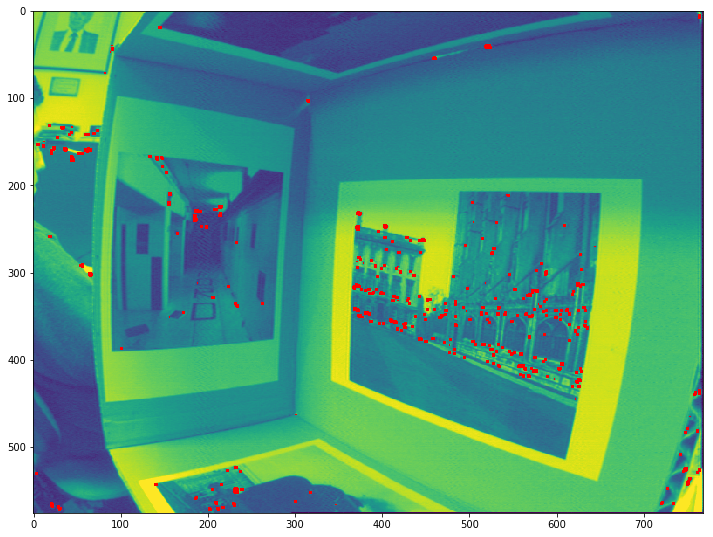

In [26]:
## Circle 16, n=12
_x, _y, points, _all = corners
plt.figure(figsize=(12, 12))
plt.imshow(box)
ax = plt.gca()

for a, b in points:
    p = patches.Rectangle((b-0.5, a-0.5), 1, 1, linewidth=2, edgecolor='r',facecolor='none')
    ax.add_patch(p);

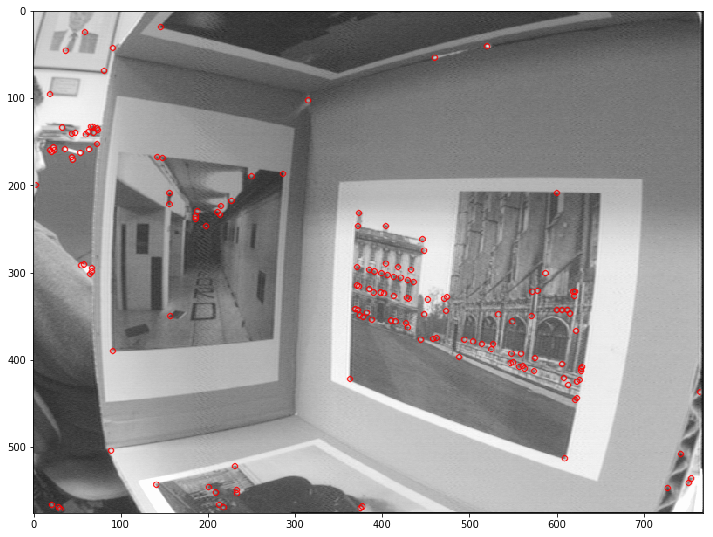

In [5]:
# Circle 16, n=9
fast = cv2.FastFeatureDetector_create(threshold=46)
kps = fast.detect(box)
plt.figure(figsize=(12, 12))
plt.imshow(cv2.drawKeypoints(box, kps, None, color=(255, 0, 0)));

### Algorithm 1 end.

* "Fast" at run-time.
* Pre-training on a large set is enough to detect a variety of corners.
* The inter-pixel tests are robust to changes in illumination.
* Some edges may be detected as False Positives.

### Algorithm 2

Measuring "cornerness" using the Harris Corner Measure.

1. The paper generalises the SSD maximisation approach proposed in [Moravec's corner detection algorithm](https://en.wikipedia.org/wiki/Corner_detection#Moravec_corner_detection_algorithm) from 1980.
2. Uses spatial gradients instead of rotations to detect "change" in a window.
3. Image smoothening is applies to minimise effect of noise and extract smooth gradients.
4. The algorithm break down corner detection into an inspection of the gradient covariance matrix.
5. Eigenvalues of this matrix can be used to label a point as a corner, edge or normal surface.
6. Instead of computing the eigenvalues, the paper proposes a heuristic $R$ to determine the "cornerness" of a point.

### Algorithm 2 cont.

Given an image patch $(u, v)$, if you "shift" the patch by a small $(x, y)$, the difference can be expressed as:

$$
E_{x, y} = \sum_{u, v} w(u, v) \big(I(u + x, v + y) - I(u, v)\big)^2
$$

$I(u + x, v + y)$ can be approximated using the first-order Taylor series terms to $I(u, v) + \big( I'_x(u, v)x + I'_y(u, v)y \big)$, leaving with

$$
E_{x, y} \approx \sum_{u, v} w(u, v) \big(I'_x(u, v)x + I'_y(u, v)y\big)^2
$$



### Algorithm 2 cont.

Square can be expanded and re-written in form $E_{x, y} \approx \begin{pmatrix} x & y \end{pmatrix} A \begin{pmatrix} x \\ y \end{pmatrix}$ where A is 

$$
A = \sum_{u, v} w(u, v) \begin{bmatrix} 
I'_x(u, v)^2 & I'_x(u, v) I'_y(u, v) \\
I'_x(u, v) I'_y(u, v) & I'_y(u, v)^2
\end{bmatrix}
$$

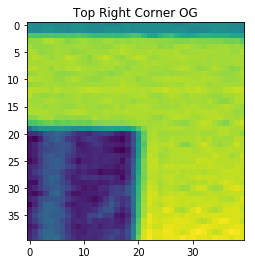

In [175]:
leftcorner = np.float32(box[190:230, 630:670])/255.0
plt.imshow(leftcorner)
plt.title("Top Right Corner OG");

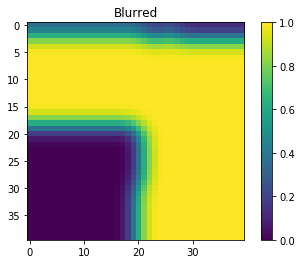

In [177]:
leftcorner[leftcorner < 0.6] = 0
leftcorner[leftcorner != 0] = 1

blur = cv2.GaussianBlur(leftcorner, (9, 9), 0)
plt.imshow(blur)
plt.title("Blurred")
plt.colorbar();

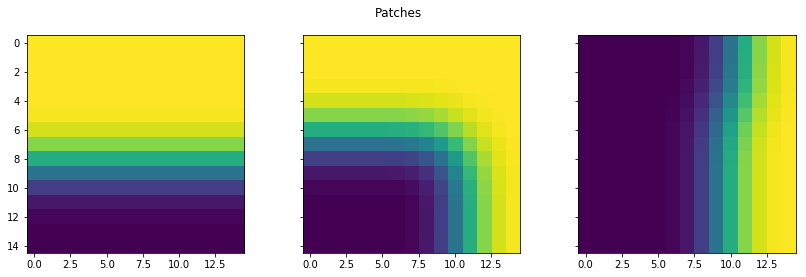

In [178]:
p1, p2, p3 = blur[10:25, :15], blur[12:27, 10:25], blur[25:40, 10:25]
patches = [p1, p2, p3]
fig, ax = plt.subplots(nrows=1, ncols=3, squeeze=False, sharey=True)
fig.set_size_inches(14, 4)
for ix, _p in enumerate(patches):
    ax[0, ix].imshow(_p);
    
fig.suptitle("Patches");

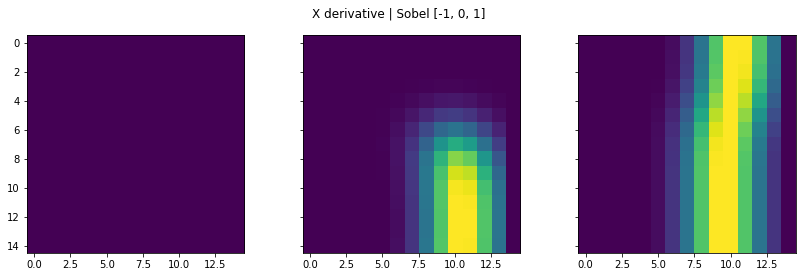

In [179]:
fig, ax = plt.subplots(nrows=1, ncols=3, squeeze=False, sharey=True)
fig.set_size_inches(14, 4)

mats_dx = []
for ix, _p in enumerate(patches):
    dx = np.zeros_like(_p)
    for c in range(1, dx.shape[1]-1):
        dx[:, c] = _p[:, c+1] - _p[:, c-1]
    
    ax[0, ix].imshow(dx);
    mats_dx.append(dx)
    
fig.suptitle("X derivative | Sobel [-1, 0, 1]");

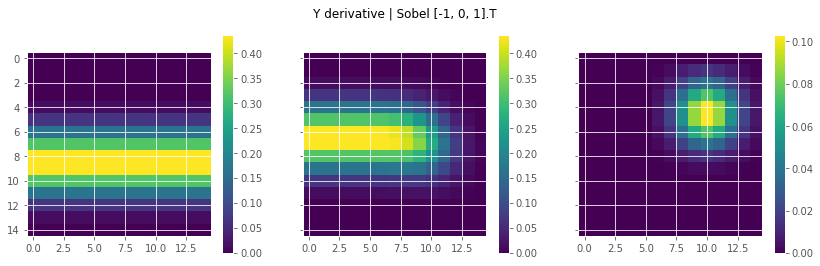

In [223]:
fig, ax = plt.subplots(nrows=1, ncols=3, squeeze=False, sharey=True)
fig.set_size_inches(14, 4)

mats_dy = []
for ix, _p in enumerate(patches):
    dy = np.zeros_like(_p)
    for r in range(1, dx.shape[0]-1):
        dy[r, :] = _p[r+1, :] - _p[r-1, :]
    
    _im = ax[0, ix].imshow(np.absolute(dy))
    mats_dy.append(dy)
    fig.colorbar(_im, ax=ax[0, ix]);
    
fig.suptitle("Y derivative | Sobel [-1, 0, 1].T");

### Algorithm 2 cont.
$$
A = \sum_{u, v} w(u, v) \begin{bmatrix} 
I'_x(u, v)^2 & I'_x(u, v) I'_y(u, v) \\
I'_x(u, v) I'_y(u, v) & I'_y(u, v)^2
\end{bmatrix}
$$

The two eigenvalues of $A$ inform us about the cornerness of the patch.

In [206]:
import seaborn as sns

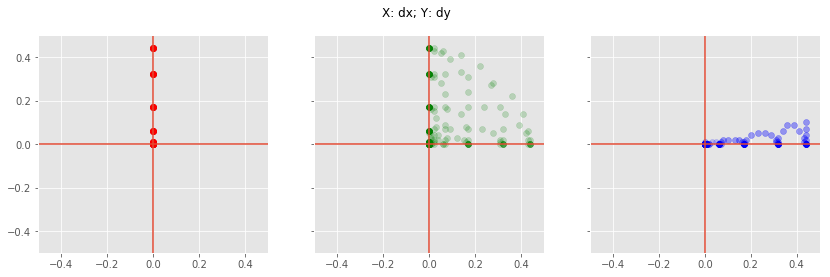

In [225]:
colors = ['red', 'green', 'blue']
fig, ax = plt.subplots(nrows=1, ncols=3, squeeze=False, sharey=True)
fig.set_size_inches(14, 4)
for c in range(3):
    ax[0, c].set_xlim(-0.5, 0.5)
    ax[0, c].set_ylim(-0.5, 0.5)
    ax[0, c].axvline(0)
    ax[0, c].axhline(0)
    ax[0, c].scatter(np.round(np.absolute(mats_dx[c].flatten()), 2), 
                     np.round(np.absolute(mats_dy[c].flatten()), 2), 
                     color=colors[c], alpha=0.2);
    
fig.suptitle("X: dx; Y: dy");

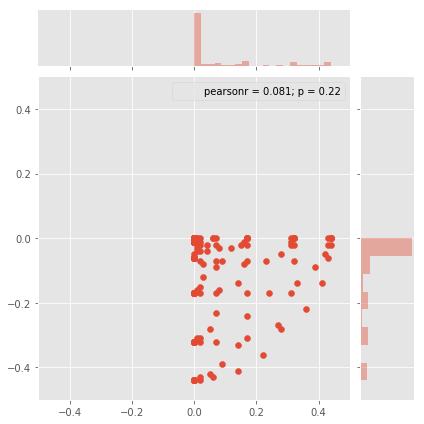

In [227]:
sns.jointplot(np.round(mats_dx[1].flatten(), 2), np.round(mats_dy[1].flatten(), 2),  
              xlim=[-0.5, 0.5], ylim=[-0.5, 0.5]);

### Algorithm 2 cont.

$$
A = \sum_{u, v} w(u, v) \begin{bmatrix} 
I'_x(u, v)^2 & I'_x(u, v) I'_y(u, v) \\
I'_x(u, v) I'_y(u, v) & I'_y(u, v)^2
\end{bmatrix}
$$

The two eigenvalues of $A$ inform us about the cornerness of the patch.
* If both large, patch is a corner.
* If only one is large, patch is an edge.
* If both small, area is plain.

### Algorithm 2 end.

Since Eigenvalue computation is expensive, authors propose a heuristic that can be used for measuring the "cornerness".

$R = \text{det}(A) - k. \text{trace}^2(A)$

$k$ is determined empirically in the paper between $[0.04, 0.06]$.

Steps:
1. Detect a large number of corners with FAST9 and a low threshold.
2. Select top $N$ corners based on $R$ values.

### Algorithm 3

How to achieve scale invariance?

* Repeat steps 1 and 2 for progressively sub-sampled images. Paper uses a scale factor of $\sqrt2$
* *Presumably* store these along with the first patch (original resolution). *This is not discussed in the paper.*

### Algorithm 4

How do we match features? You can just compute the MSE b/w patches. MSE is slow.

BRIEF: Binary Robust Independent Elementary Features, proposes a fast and efficient way to describe a feature to enable fast feature matching.
1. Given an image patch, randomly sample pairs of coordinate $(a_1, b_1), (a_2, b_2), ...$.
2. In order, store $I_a < I_b$.
3. Use Hamming Distance for fast matching.

<img src="brief_sampled_points.png" width="20%">

### Algorithm 4 cont.
Advantage: competitive against other descriptors.
<img src="brief_results.png" width="70%">

### Algorithm 4 cont.
Advantage: robust to blur, lighting.
<img src="brief_light.png" width="60%">

### Algorithm 4 cont.
Disadvantage: no rotational invariance.
<img src="brief_graffiti.png" width="60%">

### Algorithm 4 cont.

Hamming distance "discriminative" power.
<img src="brief_hamming.png" width="80%">

Is not very discriminative for large datasets. The paper addresses the discriminative power at the end.

### Algorithm 4, 5.

How do we solve rotational ivariance?

1. Compute "orientation" angle of a patch.
2. Rotate the patch to obtain a rotation invariant feature every time.

If the origin is center pixel, the orientation is the angle b/w the X-axis and the centroid of the image.

Centroid can be calculated efficiently by using spatial moments.

### Algorithm 5 cont.

To compute the centroid:
<img src="brief_ica.png" width="50%">

`np.arctan2(y, x)` gives the angle b/w the X-axis (right from origin) and the point $(x, y)$.

In [26]:
def compute_plot_ica(patch, radius):
    right = zip(range(-radius, radius+1), range(0, radius) + range(radius, -1, -1))
    left = zip(range(radius-1, -radius, -1), range(-1, -radius, -1) + range(-radius, 1, 1))

    circle = right + left

    plt.imshow(patch)
    ax = plt.gca()

    cx, cy = radius, radius
    p = patches.Rectangle(xy=(cx-0.5, cy-0.5), width=1, height=1, color='red')
    ax.add_patch(p);

    m00, m01, m10 = 0, 0, 0

    for ox, oy in circle:
        p = patches.Rectangle(xy=(cx+ox-0.5, cy+oy-0.5), width=1, height=1, fill=False, color='red')
        ax.add_patch(p);

        _ival = patch[cx+ox, cy+oy]
        m00 += _ival
        m01 += oy * _ival
        m10 += ox * _ival

    centroid = [m10/m00, m01/m00]
    print "centroid:", centroid
    print "degrees:", np.arctan2(-m10, m01) * 180 / np.pi

    p = patches.Rectangle(xy=(cx+centroid[1]-0.5, cy+centroid[0]+0.5), width=1, height=1, fill=True, color='orange')
    ax.add_patch(p);

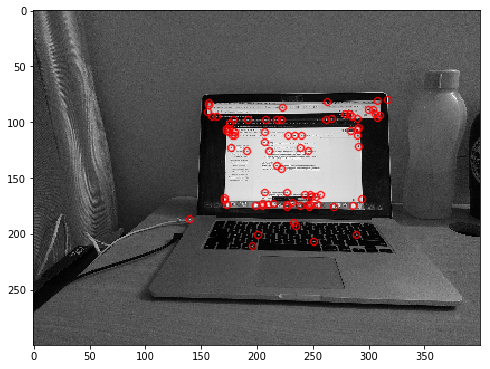

In [27]:
laptop = cv2.imread('/Users/tejaswin.p/Downloads/Fast_Brief/IMG_20200415_162336.jpg', 
                 cv2.IMREAD_GRAYSCALE)
laptop = cv2.resize(laptop, (0, 0), fx=0.1, fy=0.1)

fast = cv2.FastFeatureDetector_create(threshold=106)
kps = fast.detect(laptop)
corners = cv2.drawKeypoints(laptop, kps, None, color=(255, 0, 0))
plt.figure(figsize=(8, 8))
plt.imshow(corners);

centroid: [-3, 1]
degrees: 58.85419998155805


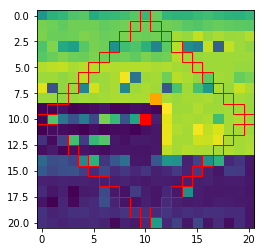

In [35]:
import matplotlib.patches as patches
n=10
ica_x, ica_y = int(kps[n].pt[1]), int(kps[n].pt[0])
ica_patch = laptop[ica_x-10:ica_x+11, ica_y-10:ica_y+11]

compute_plot_ica(ica_patch, radius=10)

### Algorithm 5 end.

* Paper only considers the pixels in a circular region of the patch.
* Instead of rotating the image, you can transform the coordinate pairs by creating a rotation matrix from the ICA.
* Angles are binned in 12 degree buckets.
* In OpenCV's implementation of ORB, these rotated BRIEF coordinates are hard-coded for every bucket, for a fixed patch size.

<img src="brief_hardcode.png" width="50%">

### Algorithm 6

We now have OrientedFAST feature patches and **Streered**BRIEF descriptors.

